In [1]:
# Library import
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
# Read data
file_path = '/content/gdrive/MyDrive/02- Intro to AI project/TwiBot-20/Twibot-20/users.csv'
df = pd.read_csv(file_path)

df.columns.values

array(['id', 'id_str', 'name', 'screen_name', 'location',
       'profile_location', 'description', 'url', 'entities', 'protected',
       'followers_count', 'friends_count', 'listed_count', 'created_at',
       'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled',
       'verified', 'statuses_count', 'lang', 'contributors_enabled',
       'is_translator', 'is_translation_enabled',
       'profile_background_color', 'profile_background_image_url',
       'profile_background_image_url_https', 'profile_background_tile',
       'profile_image_url', 'profile_image_url_https',
       'profile_link_color', 'profile_sidebar_border_color',
       'profile_sidebar_fill_color', 'profile_text_color',
       'profile_use_background_image', 'has_extended_profile',
       'default_profile', 'default_profile_image', 'neighbor', 'domain',
       'label', 'following', 'followers'], dtype=object)

In [32]:
# Data Pre-processing
# Drop duplicate row
df = df.drop_duplicates()

# Type conversion
df['label'] = df['label'].astype(int)

df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at'] = df['created_at'].dt.date
df['age'] = df['created_at'].apply(lambda x: (pd.to_datetime('2020-12-31').date() - x))
df['age'] = df['age'].dt.days / 365

df['verified'] = df['verified'].str.strip()
df['verified'] = df['verified'].astype(bool)
df['verified'] = df['verified'].astype(int)

df['screen_name_length'] = df['screen_name'].apply(lambda x: len(x))


# Replace NaN or null values with an empty string
df['followers'] = df['followers'].fillna('')
df['following'] = df['following'].fillna('')

In [33]:
# Graph creation
G = nx.DiGraph()
# Add nodes
for i, row in df.iterrows():
  G.add_node(row['id'])
# Add edges
for i, row in df.iterrows():
    followers = row['followers'].split(',')
    for follower in followers:
      # Check if follower is not an empty string or empty list
        if follower and str(follower).strip():
            G.add_edge(follower, row['id'])

# Basic graph statistics
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


degree = dict(G.degree())
pagerank = nx.pagerank(G)
# clustering = nx.clustering(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
# avg_neighbor_degree = nx.average_neighbor_degree(G)

# Create a new DataFrame with graph features
features_graph = pd.DataFrame({
    'id': list(degree.keys()),
    'degree': list(degree.values()),
    'pagerank': list(pagerank.values()),
    'closeness': list(closeness.values()),
    'eigenvector': list(eigenvector.values()),
})

# Merge the original DataFrame with the features DataFrame
df = pd.merge(df, features_graph, on='id')

Number of nodes: 79767
Number of edges: 72235


In [35]:
df.head(5)

,id,id_str,name,screen_name,location,profile_location,description,url,entities,protected,...,domain,label,following,followers,age,screen_name_length,degree,pagerank,closeness,eigenvector
0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL","{'id': '55b4f9e5c516e0b6', 'url': 'https://api...","VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",https://t.co/7hsiK8cCKW,{'url': {'urls': [{'url': 'https://t.co/7hsiK8...,False,...,"['Politics', 'Business', 'Entertainment']",0,,,12.126027,5,0,0.000007,0.000000,0.000035
1,1297437077403885568,1297437077403885568,Jennifer Fishpaw,JenniferFishpaw,,None,,None,{'description': {'urls': []}},False,...,['Politics'],1,"['170861207', '23970102', '47293791', '2945807...",[],0.356164,16,1,0.000007,0.000013,0.001214
2,17685258,17685258,Brad Parscale,parscale,Florida,None,Owner @ Parscale Strategy. Senior Advisor Digi...,https://t.co/GooZcYDqFg,{'url': {'urls': [{'url': 'https://t.co/GooZcY...,False,...,"['Politics', 'Entertainment', 'Sports']",0,"['46464108', '21536398', '18643437', '58949002...","['1275068515666386945', '2535843469', '1293657...",12.101370,9,10,0.000065,0.000125,0.011829
3,15750898,15750898,FOX 13 Tampa Bay,FOX13News,"Tampa, FL",None,Bringing you the important stuff like breaking...,https://t.co/RtP9QYEZCq,{'url': {'urls': [{'url': 'https://t.co/RtP9QY...,False,...,['Politics'],0,"['2324715174', '24030137', '2336676015', '1926...","['855194021458739200', '1267566832598290432', ...",12.410959,10,10,0.000065,0.000125,0.011829
4,1659167666,1659167666,Vonte The Plug 🎤🔌,VonteThePlugNC,"Jacksonville Beach, FL","{'id': '5e281c17a74c170f', 'url': 'https://api...",MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,https://t.co/5cY8GWvk8E,{'url': {'urls': [{'url': 'https://t.co/5cY8GW...,False,...,['Politics'],1,"['1628313708', '726405625', '130868956', '2665...","['893137540185718785', '1063858543', '26665819...",7.397260,15,10,0.000065,0.000125,0.011829


In [46]:
columns = ['degree', 'pagerank', 'friends_count', 'eigenvector', 'closeness']

print(f"\nOverall:")
for col in columns:
    display(df[col].describe().round(2).to_frame().T)




Overall:


,count,mean,std,min,25%,50%,75%,max
degree,8278.0,8.73,3.19,0.0,10.0,10.0,10.0,10.0


,count,mean,std,min,25%,50%,75%,max
pagerank,8278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
friends_count,8278.0,6609.92,63778.57,0.0,231.0,723.0,2124.0,4339982.0


,count,mean,std,min,25%,50%,75%,max
eigenvector,8278.0,0.01,0.0,0.0,0.01,0.01,0.01,0.01


,count,mean,std,min,25%,50%,75%,max
closeness,8278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
print(f"\n Label = 1 (Bots):")
for col in columns:
  display(df.loc[df['label'] == 1, col].describe().round(2).to_frame().T)


 Label = 1 (Bots):


,count,mean,std,min,25%,50%,75%,max
degree,4646.0,9.34,2.24,0.0,10.0,10.0,10.0,10.0


,count,mean,std,min,25%,50%,75%,max
pagerank,4646.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
friends_count,4646.0,4967.14,22843.39,0.0,259.0,824.5,2631.5,693457.0


,count,mean,std,min,25%,50%,75%,max
eigenvector,4646.0,0.01,0.0,0.0,0.01,0.01,0.01,0.01


,count,mean,std,min,25%,50%,75%,max
closeness,4646.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
print(f"\n Label = 0 (Humans):")
for col in columns:
  display(df.loc[df['label'] == 0, col].describe().round(2).to_frame().T)


 Label = 0 (Humans):


,count,mean,std,min,25%,50%,75%,max
degree,3632.0,7.94,3.96,0.0,10.0,10.0,10.0,10.0


,count,mean,std,min,25%,50%,75%,max
pagerank,3632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
friends_count,3632.0,8711.33,92720.39,0.0,202.0,612.5,1643.75,4339982.0


,count,mean,std,min,25%,50%,75%,max
eigenvector,3632.0,0.01,0.0,0.0,0.01,0.01,0.01,0.01


,count,mean,std,min,25%,50%,75%,max
closeness,3632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Features
features_account = ['age', 'screen_name_length', 'statuses_count', 'favourites_count']
features_graph = ['followers_count', 'friends_count', 'degree', 'closeness', 'eigenvector']
features_graph_all = features_graph + ['pagerank', 'clustering', 'avg_neighbor_degree']
features_all = features_graph_all + features_account

In [29]:
df.columns

Index(['id', 'id_str', 'name', 'screen_name', 'location', 'profile_location',
       'description', 'url', 'entities', 'protected', 'followers_count',
       'friends_count', 'listed_count', 'created_at', 'favourites_count',
       'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count',
       'lang', 'contributors_enabled', 'is_translator',
       'is_translation_enabled', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_image_url',
       'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'has_extended_profile', 'default_profile', 'default_profile_image',
       'neighbor', 'domain', 'label', 'following', 'followers', 'age',
       'screen_name_length', 'degree', 'pagerank', 'closeness', 'eigenvector'],
      dtype='object')

In [28]:
features_all

['followers_count',
 'friends_count',
 'degree',
 'closeness',
 'eigenvector',
 'pagerank',
 'clustering',
 'avg_neighbor_degree',
 'age',
 'screen_name_length',
 'statuses_count',
 'favourites_count']

In [54]:
correlations = df[df.columns].corrwith(df['label'])
print(correlations)

id_str                0.147199
followers_count      -0.169829
friends_count        -0.029134
listed_count         -0.159058
favourites_count      0.052047
verified                   NaN
statuses_count       -0.074761
label                 1.000000
age                  -0.212925
screen_name_length    0.080036
degree                0.219057
pagerank              0.208251
closeness             0.219057
eigenvector           0.219057
dtype: float64


<ipython-input-54-3f3ddd0b5a4c>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df[df.columns].corrwith(df['label'])


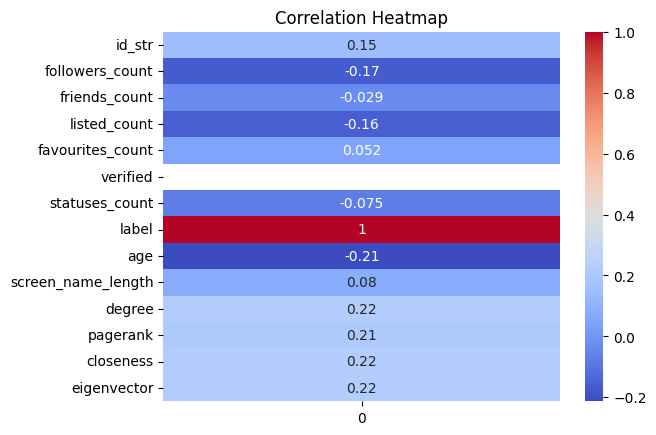

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
sns.heatmap(correlations.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Accuracy: 0.6545893719806763
Precision: 0.6869479882237488
Recall: 0.7345225603357818
              precision    recall  f1-score   support

           0       0.60      0.55      0.57       703
           1       0.69      0.73      0.71       953

    accuracy                           0.65      1656
   macro avg       0.64      0.64      0.64      1656
weighted avg       0.65      0.65      0.65      1656



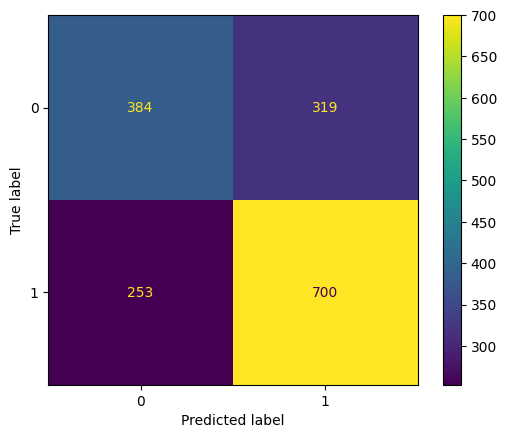

In [ ]:
# Experiment 1: user account
X = df[features_account]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
y_pred_cutoff = np.array([True if pred > 0.5 else False for pred in y_pred])
print(classification_report(y_test, y_pred_cutoff))
cm = confusion_matrix(y_test, y_pred_cutoff)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Text(0.5, 1.0, 'ROC Curve')

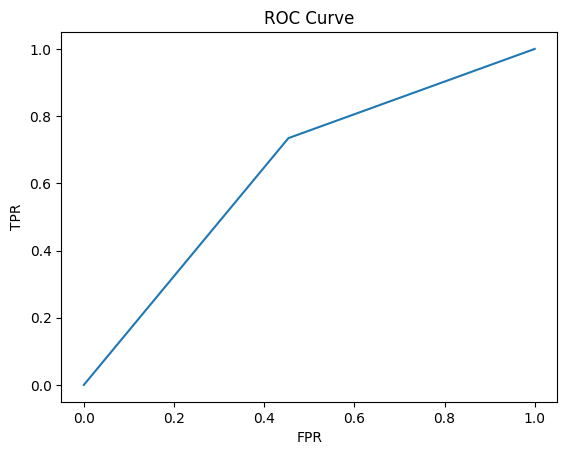

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title("ROC Curve")
auc_score = roc_auc_score(y_test, y_pred)
print(f'AUC score: {auc_score:.2f}')

Accuracy: 0.7125603864734299
Precision: 0.7256385998107853
Recall: 0.8048268625393494
              precision    recall  f1-score   support

           0       0.69      0.59      0.63       703
           1       0.73      0.80      0.76       953

    accuracy                           0.71      1656
   macro avg       0.71      0.70      0.70      1656
weighted avg       0.71      0.71      0.71      1656



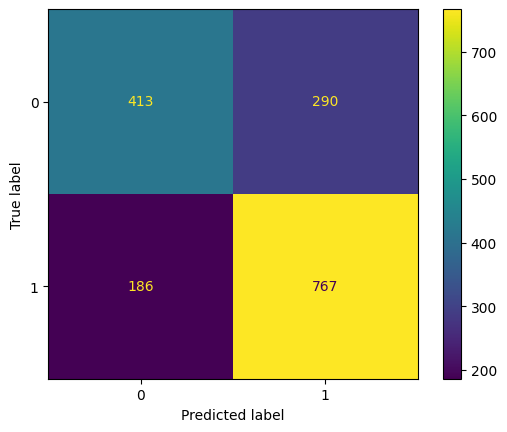

In [ ]:
# Experiment 2: network counts and graph analysis as features
X = df[features_graph]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
y_pred_cutoff = np.array([True if pred > 0.5 else False for pred in y_pred])
print(classification_report(y_test, y_pred_cutoff))
cm = confusion_matrix(y_test, y_pred_cutoff)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Text(0.5, 1.0, 'ROC Curve')

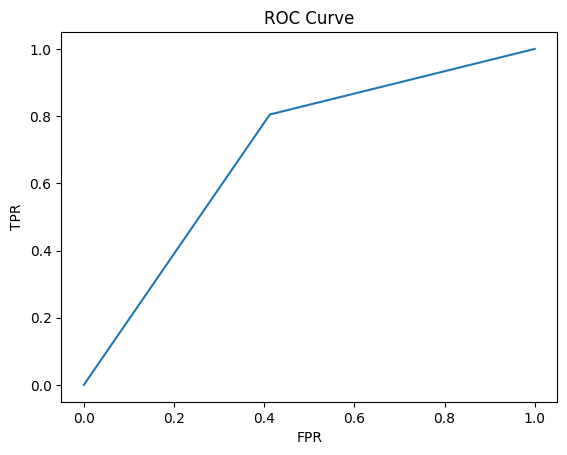

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title("ROC Curve")

Accuracy: 0.751207729468599
Precision: 0.7404444444444445
Recall: 0.8740818467995802
              precision    recall  f1-score   support

           0       0.77      0.58      0.67       703
           1       0.74      0.87      0.80       953

    accuracy                           0.75      1656
   macro avg       0.76      0.73      0.73      1656
weighted avg       0.75      0.75      0.74      1656



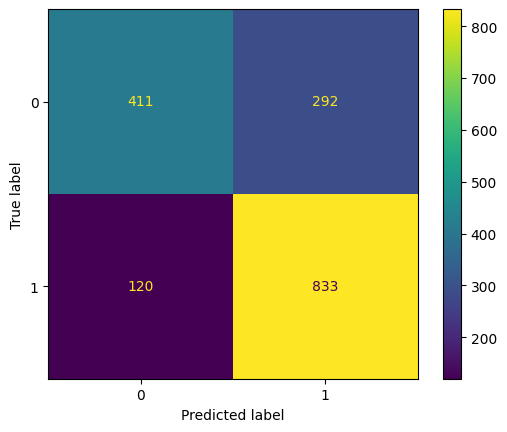

In [ ]:
# Experiment 3: all of them: user account, network counts and graph analysis as features
X = df[features_account + features_graph]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
y_pred_cutoff = np.array([True if pred > 0.5 else False for pred in y_pred])
print(classification_report(y_test, y_pred_cutoff))
cm = confusion_matrix(y_test, y_pred_cutoff)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Text(0.5, 1.0, 'ROC Curve')

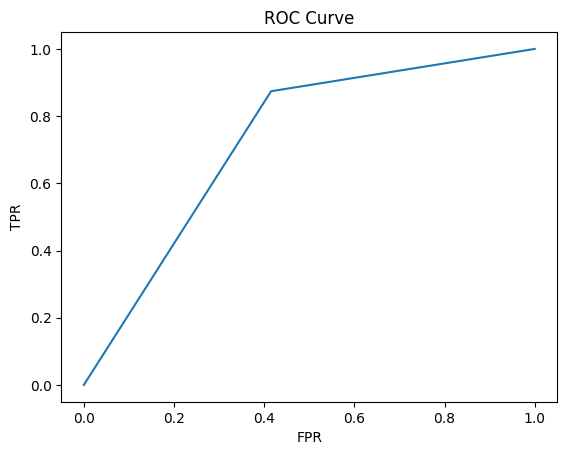

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title("ROC Curve")